In [25]:
from odyssey.utils import *
from odyssey.core.bigquery.BigQueryGithubEntry import *
from odyssey.core.analyzer import InstantiationAnalyzer 
import matplotlib.pyplot as plt

from odyssey.core.bigquery.GithubPython import GithubPython 
%matplotlib notebook 

Exclude the repos that are fork of sklearn, hence remove the files with repo_name/ path as 'sklearn'

In [10]:
query = """\
SELECT
    DISTINCT(sample_repo_name)
FROM
    `Odyssey_github_sklearn.content_ipynb` 
WHERE
    (REGEXP_CONTAINS(sample_path,"sklearn")) OR
    (REGEXP_CONTAINS(sample_repo_name,"scikit-learn")) OR
    (REGEXP_CONTAINS(sample_repo_name,"sklearn")) OR
    (REGEXP_CONTAINS(sample_path,"scikit-learn"))
"""
gp = GithubPython()

In [11]:
excludedRepos = [sample_repo_name[0] for sample_repo_name in gp.run(query, project="odyssey-193217")]
print(excludedRepos)

['Yu-Group/scikit-learn-sandbox', 'rickiepark/python-tutorial', 'marcelomiky/PythonCodes', 'palandatarxcom/sklearn_tutorial_cn', 'jaganadhg/data_science_notebooks', 'DavidBrear/sklearn-cookbook', 'amueller/sklearn_workshop', 'moonbury/pythonanywhere', 'hyperopt/hyperopt-sklearn', 'astroML/sklearn_tutorial', 'amueller/sklearn_014_015_pydata', 'chrinide/optunity', 'STREAM3/pyisc', 'everestso/ics1293', 'yhs-968/yhs-968.github.io', 'peterwittek/qml-rg', 'mikessoldier/mikessoldier.bigd.py', 'raincoatrun/sklearn_tutorial', 'astro4dev/OAD-Data-Science-Toolkit', 'computational-class/cjc2016', 'jmschrei/pomegranate', 'rjurney/Agile_Data_Code_2', 'summanlp/gensim', 'vzhong/posts-notebooks', 'JanetMatsen/Machine_Learning_CSE_546', 'idwaker/sklearn_pydata2015', 'mayankjohri/LetsExplorePython', 'woters/ds101', 'ageek/mml_sklearn', 'amueller/pydata-nyc-advanced-sklearn', 'adamwalz/Jupyter-Notebooks', 'amueller/scipy_2015_sklearn_tutorial', 'JeffAbrahamson/MLWeek', 'mhdella/sklearn_pycon2015', 'atuls

In [12]:
def excludeByRepoFull(excludeByRepos):
    if not excludedRepos:
        return ""
    s = '(NOT REGEXP_CONTAINS(sample_repo_name,"%s"))' % excludedRepos[0]
    for repo in excludedRepos[1:]:
        s += ' AND '
        s += '(NOT REGEXP_CONTAINS(sample_repo_name,"%s"))' % repo
    return s

print(excludeByRepoFull(excludedRepos))

(NOT REGEXP_CONTAINS(sample_repo_name,"Yu-Group/scikit-learn-sandbox")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"rickiepark/python-tutorial")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"marcelomiky/PythonCodes")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"palandatarxcom/sklearn_tutorial_cn")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"jaganadhg/data_science_notebooks")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"DavidBrear/sklearn-cookbook")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"amueller/sklearn_workshop")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"moonbury/pythonanywhere")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"hyperopt/hyperopt-sklearn")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"astroML/sklearn_tutorial")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"amueller/sklearn_014_015_pydata")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"chrinide/optunity")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"STREAM3/pyisc")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"everestso/ics1293")) 

### Extracting the python files which includes scikit learn

In [13]:
pythonFilesThatContainsSklearn = """\
SELECT
    COUNT(*) count 
FROM
    `Odyssey_github_sklearn.content_ipynb`
WHERE
    %s AND (REGEXP_CONTAINS(content,"sklearn"))
""" % excludeByRepoFull(excludedRepos)

In [14]:
result = gp.run(pythonFilesThatContainsSklearn)

In [15]:
sklearnFile = result[0][0]
print(sklearnFile)

11689


In [16]:
howManyPythonFiles = """\
SELECT
    COUNT(*) count
FROM
    `Odyssey_github_sklearn.content_ipynb`
WHERE
    %s
""" % excludeByRepoFull(excludedRepos)

totalFile = gp.run(howManyPythonFiles)[0][0]

In [17]:
print(totalFile)

105980


<IPython.core.display.Javascript object>


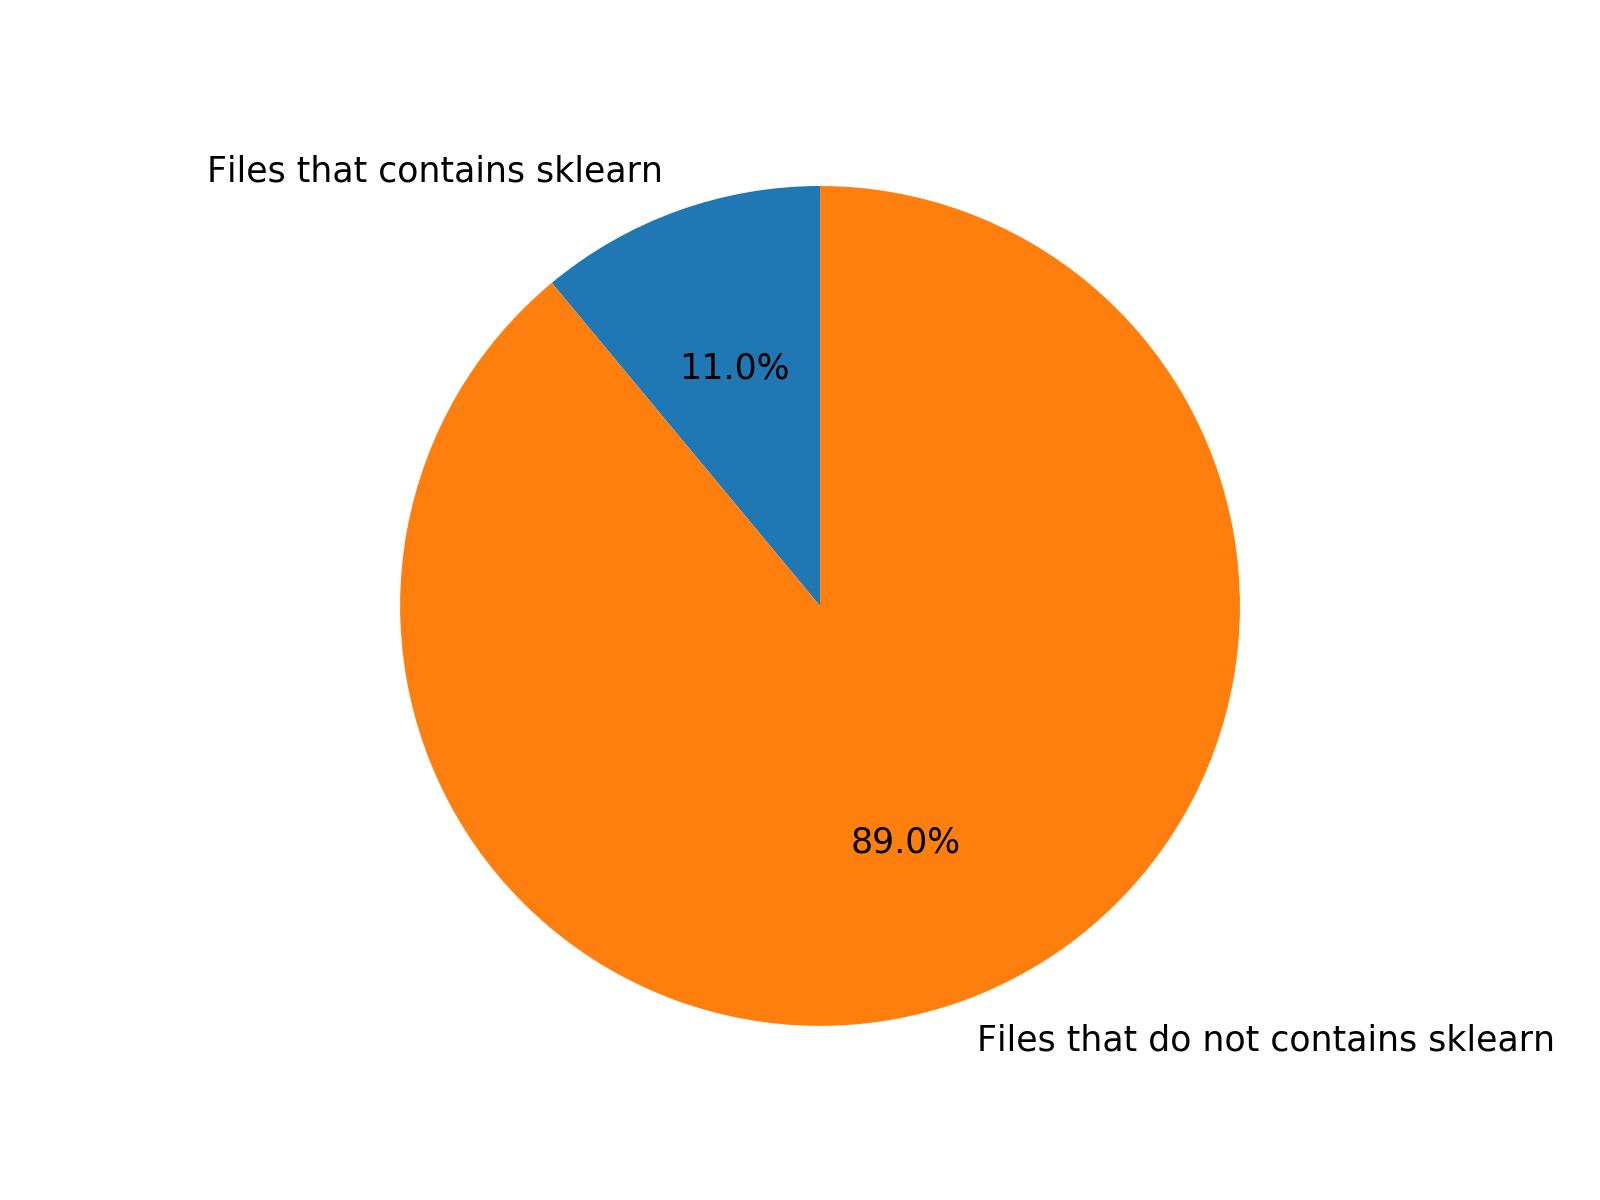

In [18]:
labels = 'Files that contains sklearn', 'Files that do not contains sklearn'
sizes = [sklearnFile, totalFile-sklearnFile]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [19]:
print(excludeByRepoFull(excludedRepos))

(NOT REGEXP_CONTAINS(sample_repo_name,"Yu-Group/scikit-learn-sandbox")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"rickiepark/python-tutorial")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"marcelomiky/PythonCodes")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"palandatarxcom/sklearn_tutorial_cn")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"jaganadhg/data_science_notebooks")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"DavidBrear/sklearn-cookbook")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"amueller/sklearn_workshop")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"moonbury/pythonanywhere")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"hyperopt/hyperopt-sklearn")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"astroML/sklearn_tutorial")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"amueller/sklearn_014_015_pydata")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"chrinide/optunity")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"STREAM3/pyisc")) AND (NOT REGEXP_CONTAINS(sample_repo_name,"everestso/ics1293")) 

### Repositories that import scikit learn module in its files

In [20]:
repoThatImportsSklearnTheMostQuery = """\
SELECT sample_repo_name , COUNT(*) count
FROM (
      SELECT line, sample_repo_name
      FROM(
      SELECT SPLIT(content, '\\n') as lines, sample_repo_name
      FROM
      `Odyssey_github_sklearn.content_ipynb`
      ), UNNEST(lines) line
      
      WHERE ((REGEXP_CONTAINS(line, 'from sklearn.')) OR
      (REGEXP_CONTAINS(line, 'import sklearn'))) AND %s
     )
     
     GROUP BY 1
ORDER BY count DESC
""" % excludeByRepoFull(excludedRepos)
repoThatImportsSklearnTheMost = gp.run(repoThatImportsSklearnTheMostQuery)

<IPython.core.display.Javascript object>


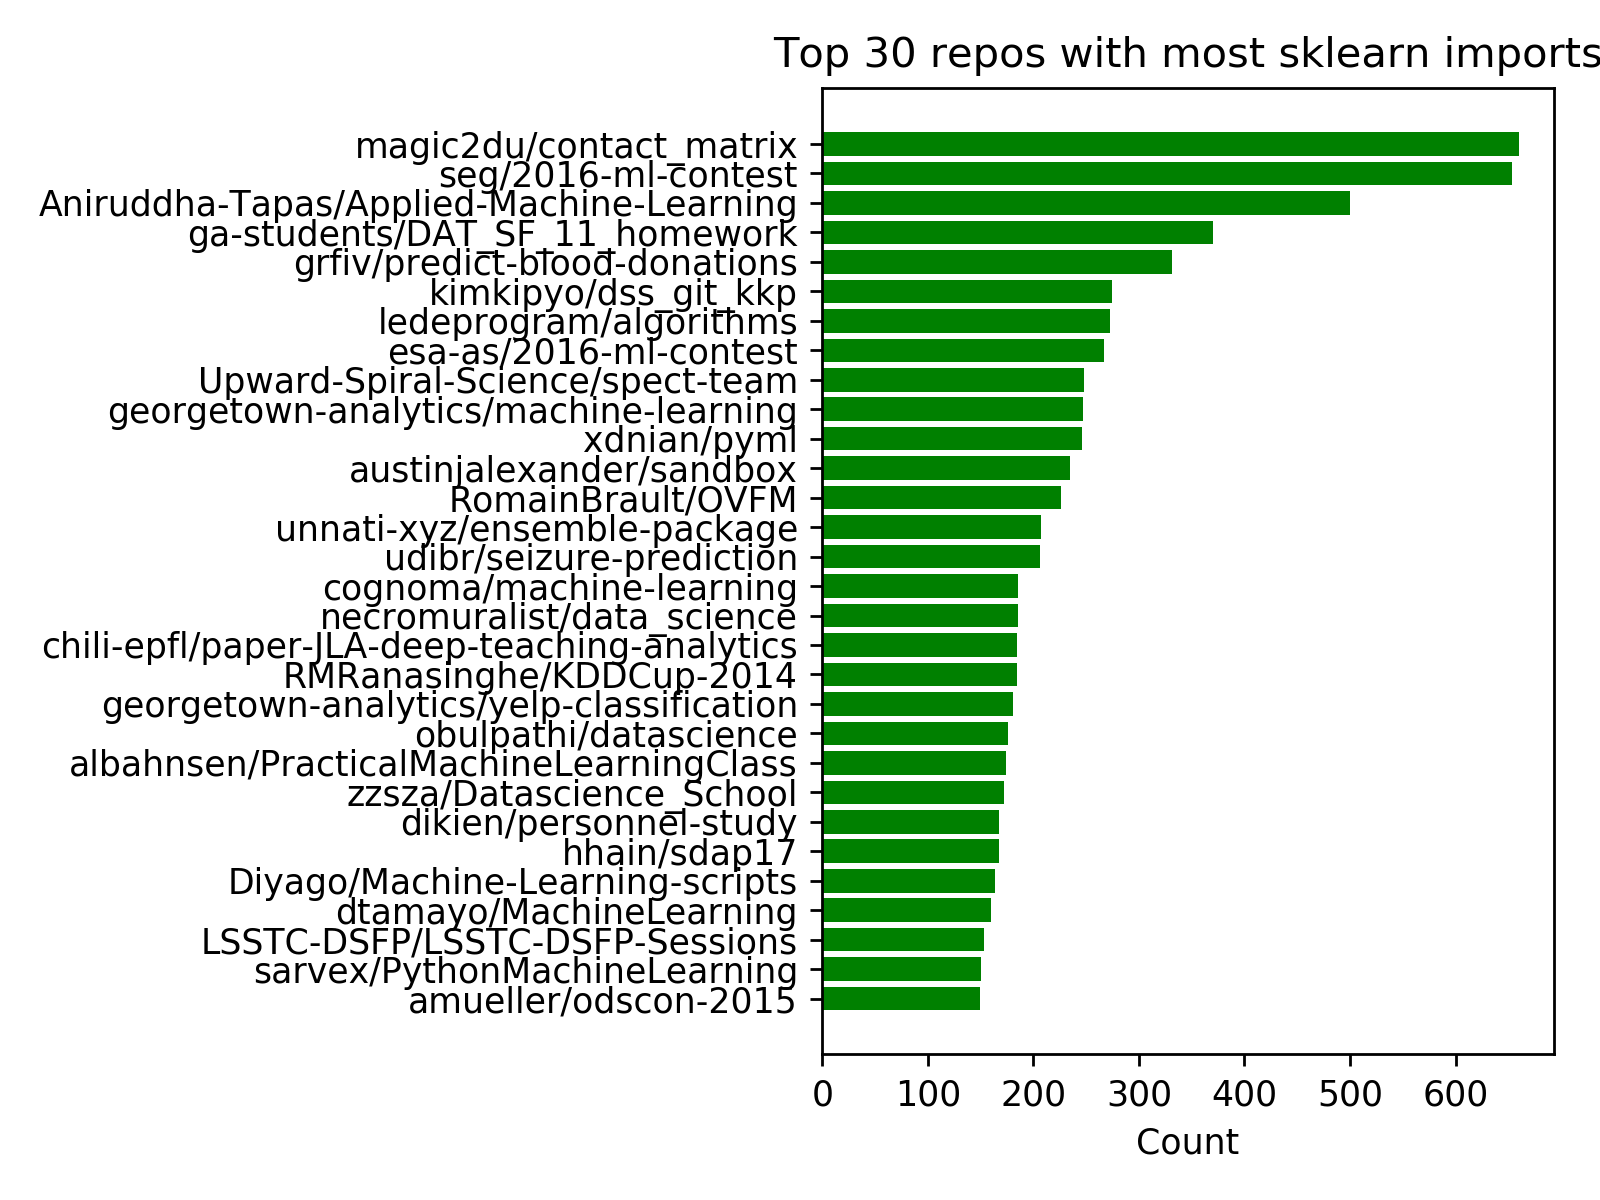

In [21]:
fig, ax = plt.subplots()

repos = [repo for repo, _ in repoThatImportsSklearnTheMost[:30]]
y_pos = range(len(repos))
count = [count for _, count in repoThatImportsSklearnTheMost[:30]]

ax.barh(y_pos, count, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(repos)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_title('Top 30 repos with most sklearn imports')
plt.tight_layout()

In [28]:
repoAndPathThatImportsSklearnQuery = """\
SELECT sample_repo_name as repo_name, sample_path as path
FROM (
      SELECT line, sample_repo_name, sample_path
      FROM(
      SELECT SPLIT(content, '\\n') as lines, sample_repo_name, sample_path
      FROM
      `Odyssey_github_sklearn.content_ipynb`
      ), UNNEST(lines) line
      
      WHERE ((REGEXP_CONTAINS(line, 'from sklearn.')) OR
      (REGEXP_CONTAINS(line, 'import sklearn'))) AND %s
     )
""" % excludeByRepoFull(excludedRepos)
repoAndPathThatImportsSklearn = gp.run(repoAndPathThatImportsSklearnQuery)

### URLS of the repo and the files which import scikit learn

In [30]:
print(len(repoAndPathThatImportsSklearn))
for i in range(len(repoAndPathThatImportsSklearn)):
    print(BigQueryGithubEntry.get_url(repoAndPathThatImportsSklearn[i]))
    #print(repoAndPathThatImportsSklearn[i])

46256
https://github.com/gtrichards/PHYS_T480/tree/master/Classification.ipynb
https://github.com/gtrichards/PHYS_T480/tree/master/Classification.ipynb
https://github.com/gtrichards/PHYS_T480/tree/master/Classification.ipynb
https://github.com/gtrichards/PHYS_T480/tree/master/Classification.ipynb
https://github.com/gtrichards/PHYS_T480/tree/master/Classification.ipynb
https://github.com/gtrichards/PHYS_T480/tree/master/Classification.ipynb
https://github.com/gtrichards/PHYS_T480/tree/master/Classification.ipynb
https://github.com/gtrichards/PHYS_T480/tree/master/Classification.ipynb
https://github.com/gtrichards/PHYS_T480/tree/master/Classification.ipynb
https://github.com/gtrichards/PHYS_T480/tree/master/Classification.ipynb
https://github.com/gtrichards/PHYS_T480/tree/master/Classification.ipynb
https://github.com/gtrichards/PHYS_T480/tree/master/Classification.ipynb
https://github.com/gtrichards/PHYS_T480/tree/master/Classification.ipynb
https://github.com/gtrichards/PHYS_T480/tree/

https://github.com/adam2392/paremap/tree/master/notebooks/descriptive_analysis/.ipynb_checkpoints/descriptive_analysis_sessionblocks-checkpoint.ipynb
https://github.com/rabbanyk/CommunityEvaluation/tree/master/Clustering Agreement.ipynb
https://github.com/sharpround/mimic-analysis/tree/master/los_model_optimize.ipynb
https://github.com/sharpround/mimic-analysis/tree/master/los_model_optimize.ipynb
https://github.com/sharpround/mimic-analysis/tree/master/los_model_optimize.ipynb
https://github.com/sharpround/mimic-analysis/tree/master/los_model_optimize.ipynb
https://github.com/sharpround/mimic-analysis/tree/master/los_model_optimize.ipynb
https://github.com/sharpround/mimic-analysis/tree/master/los_model_optimize.ipynb
https://github.com/sharpround/mimic-analysis/tree/master/los_model_optimize.ipynb
https://github.com/sharpround/mimic-analysis/tree/master/los_model_optimize.ipynb
https://github.com/sharpround/mimic-analysis/tree/master/los_model_optimize.ipynb
https://github.com/tuwien

https://github.com/tum-camp/survival-support-vector-machine/tree/master/examples/survival-svm.ipynb
https://github.com/ledeprogram/algorithms/tree/master/class7/homework/shuyao_xiao_7_assignment.ipynb
https://github.com/ledeprogram/algorithms/tree/master/class7/homework/shuyao_xiao_7_assignment.ipynb
https://github.com/setiQuest/ML4SETI/tree/master/tutorials/Step_4_Classify_with_WatsonVR_old.ipynb
https://github.com/setiQuest/ML4SETI/tree/master/tutorials/Step_4_Classify_with_WatsonVR_old.ipynb
https://github.com/VCG/gp/tree/master/ipy_train/train_RGBA.ipynb
https://github.com/e6-1/dl6-1/tree/master/Project.ipynb
https://github.com/e6-1/dl6-1/tree/master/Project.ipynb
https://github.com/AchyuthIIIT/mediacloud/tree/master/python_scripts/notebook/partisan_coding_verify.ipynb
https://github.com/AchyuthIIIT/mediacloud/tree/master/python_scripts/notebook/partisan_coding_verify.ipynb
https://github.com/AchyuthIIIT/mediacloud/tree/master/python_scripts/notebook/partisan_coding_verify.ipynb
ht

https://github.com/ga-students/DAT_SF_11_homework/tree/master/ArthurConner/hw_4-arthurconner.ipynb
https://github.com/jakevdp/OsloWorkshop2014/tree/master/notebooks/02.4_MachineLearningBreakout.ipynb
https://github.com/lrayle/rental-listings-census/tree/master/src/rental_listings_modeling.ipynb
https://github.com/lrayle/rental-listings-census/tree/master/src/rental_listings_modeling.ipynb
https://github.com/lrayle/rental-listings-census/tree/master/src/rental_listings_modeling.ipynb
https://github.com/lrayle/rental-listings-census/tree/master/src/rental_listings_modeling.ipynb
https://github.com/lrayle/rental-listings-census/tree/master/src/rental_listings_modeling.ipynb
https://github.com/lrayle/rental-listings-census/tree/master/src/rental_listings_modeling.ipynb
https://github.com/lrayle/rental-listings-census/tree/master/src/rental_listings_modeling.ipynb
https://github.com/lrayle/rental-listings-census/tree/master/src/rental_listings_modeling.ipynb
https://github.com/lrayle/rental

https://github.com/jbliss1234/ML/tree/master/T81_DNN_Kaggle.ipynb
https://github.com/jbliss1234/ML/tree/master/T81_DNN_Kaggle.ipynb
https://github.com/jbliss1234/ML/tree/master/T81_DNN_Kaggle.ipynb
https://github.com/domluna/cgt_tutorials/tree/master/neural net - digits.ipynb
https://github.com/domluna/cgt_tutorials/tree/master/neural net - digits.ipynb
https://github.com/domluna/cgt_tutorials/tree/master/neural net - digits.ipynb
https://github.com/domluna/cgt_tutorials/tree/master/neural net - digits.ipynb
https://github.com/LDSSA/learning-units/tree/master/units/12-training-and-test-set/examples/predicting-pokemon-type-example.ipynb
https://github.com/LDSSA/learning-units/tree/master/units/12-training-and-test-set/examples/predicting-pokemon-type-example.ipynb
https://github.com/LDSSA/learning-units/tree/master/units/12-training-and-test-set/examples/predicting-pokemon-type-example.ipynb
https://github.com/hayatoy/cloudml-magic/tree/master/examples/Keras Online Prediction Example.ip

https://github.com/jcharit1/Identifying-Ad-Images/tree/master/code/.ipynb_checkpoints/model_training-checkpoint.ipynb
https://github.com/jcharit1/Identifying-Ad-Images/tree/master/code/.ipynb_checkpoints/model_training-checkpoint.ipynb
https://github.com/jcharit1/Identifying-Ad-Images/tree/master/code/.ipynb_checkpoints/model_training-checkpoint.ipynb
https://github.com/jcharit1/Identifying-Ad-Images/tree/master/code/.ipynb_checkpoints/model_training-checkpoint.ipynb
https://github.com/jcharit1/Identifying-Ad-Images/tree/master/code/.ipynb_checkpoints/model_training-checkpoint.ipynb
https://github.com/jcharit1/Identifying-Ad-Images/tree/master/code/.ipynb_checkpoints/model_training-checkpoint.ipynb
https://github.com/mdtraj/mdtraj/tree/master/examples/principal-components.ipynb
https://github.com/Kebniss/TalkingData-Mobile-User-Demographics/tree/master/notebooks/data_exploration/app_labels_exploration.ipynb
https://github.com/Neuroglycerin/neukrill-net-work/tree/master/notebooks/model_

https://github.com/bwc126/MLND-Subvocal/tree/master/Subvocal.ipynb
https://github.com/bwc126/MLND-Subvocal/tree/master/Subvocal.ipynb
https://github.com/bwc126/MLND-Subvocal/tree/master/Subvocal.ipynb
https://github.com/bwc126/MLND-Subvocal/tree/master/Subvocal.ipynb
https://github.com/bwc126/MLND-Subvocal/tree/master/Subvocal.ipynb
https://github.com/bwc126/MLND-Subvocal/tree/master/Subvocal.ipynb
https://github.com/bwc126/MLND-Subvocal/tree/master/Subvocal.ipynb
https://github.com/bwc126/MLND-Subvocal/tree/master/Subvocal.ipynb
https://github.com/bwc126/MLND-Subvocal/tree/master/Subvocal.ipynb
https://github.com/bwc126/MLND-Subvocal/tree/master/Subvocal.ipynb
https://github.com/bwc126/MLND-Subvocal/tree/master/Subvocal.ipynb
https://github.com/cognoma/machine-learning/tree/master/algorithms/PassiveAggressive-KT12.ipynb
https://github.com/cognoma/machine-learning/tree/master/algorithms/PassiveAggressive-KT12.ipynb
https://github.com/cognoma/machine-learning/tree/master/algorithms/Pass

https://github.com/albahnsen/ML_SecurityInformatics/tree/master/notebooks/07-feature_selection.ipynb
https://github.com/albahnsen/ML_SecurityInformatics/tree/master/notebooks/07-feature_selection.ipynb
https://github.com/albahnsen/ML_SecurityInformatics/tree/master/notebooks/07-feature_selection.ipynb
https://github.com/albahnsen/ML_SecurityInformatics/tree/master/notebooks/07-feature_selection.ipynb
https://github.com/spulido99/Programacion/tree/master/Camilo/.ipynb_checkpoints/Taller 3 y 4-checkpoint.ipynb
https://github.com/spulido99/Programacion/tree/master/Camilo/.ipynb_checkpoints/Taller 3 y 4-checkpoint.ipynb
https://github.com/spulido99/Programacion/tree/master/Camilo/.ipynb_checkpoints/Taller 3 y 4-checkpoint.ipynb
https://github.com/spulido99/Programacion/tree/master/Camilo/.ipynb_checkpoints/Taller 3 y 4-checkpoint.ipynb
https://github.com/spulido99/Programacion/tree/master/Camilo/.ipynb_checkpoints/Taller 3 y 4-checkpoint.ipynb
https://github.com/spulido99/Programacion/tree

https://github.com/jimthompson5802/kaggle-BNP-Paribas/tree/master/src/sandbox/test_notebook.ipynb
https://github.com/jimthompson5802/kaggle-BNP-Paribas/tree/master/src/sandbox/test_notebook.ipynb
https://github.com/jimthompson5802/kaggle-BNP-Paribas/tree/master/src/sandbox/test_notebook.ipynb
https://github.com/artiomka/kaggle/tree/master/NormalizeAndSave.ipynb
https://github.com/artiomka/kaggle/tree/master/NormalizeAndSave.ipynb
https://github.com/artiomka/kaggle/tree/master/NormalizeAndSave.ipynb
https://github.com/artiomka/kaggle/tree/master/NormalizeAndSave.ipynb
https://github.com/artiomka/kaggle/tree/master/NormalizeAndSave.ipynb
https://github.com/artiomka/kaggle/tree/master/NormalizeAndSave.ipynb
https://github.com/artiomka/kaggle/tree/master/NormalizeAndSave.ipynb
https://github.com/uwkejia/Clean-Energy-Outlook/tree/master/examples/Extra/Jupyter Notebooks/OilPrice.ipynb
https://github.com/petermchale/yeast_bioinformatics/tree/master/analysis.ipynb
https://github.com/rdjdejong/

https://github.com/statkclee/ml/tree/master/14-ml-data-munging.ipynb
https://github.com/statkclee/ml/tree/master/14-ml-data-munging.ipynb
https://github.com/statkclee/ml/tree/master/14-ml-data-munging.ipynb
https://github.com/marikgoldstein/Music-Computing-NEC/tree/master/music_notebooks/beat_synchronous_chroma.ipynb
https://github.com/ledeprogram/algorithms/tree/master/class9/homework/Gruen_Gianna_9_1.ipynb
https://github.com/ledeprogram/algorithms/tree/master/class9/homework/Gruen_Gianna_9_1.ipynb
https://github.com/ledeprogram/algorithms/tree/master/class9/homework/Gruen_Gianna_9_1.ipynb
https://github.com/ledeprogram/algorithms/tree/master/class9/homework/Gruen_Gianna_9_1.ipynb
https://github.com/msampathkumar/datadriven_pumpit/tree/master/PumpIt-04.ipynb
https://github.com/msampathkumar/datadriven_pumpit/tree/master/PumpIt-04.ipynb
https://github.com/msampathkumar/datadriven_pumpit/tree/master/PumpIt-04.ipynb
https://github.com/msampathkumar/datadriven_pumpit/tree/master/PumpIt-04

https://github.com/pocman/cs109/tree/master/HW0.ipynb
https://github.com/dragoon/kilogram/tree/master/notebooks/ml_grammar.ipynb
https://github.com/dragoon/kilogram/tree/master/notebooks/ml_grammar.ipynb
https://github.com/dragoon/kilogram/tree/master/notebooks/ml_grammar.ipynb
https://github.com/amueller/pydata-strata-2015/tree/master/Chapter 4 - Grid Searches for Hyper Parameters.ipynb
https://github.com/amueller/pydata-strata-2015/tree/master/Chapter 4 - Grid Searches for Hyper Parameters.ipynb
https://github.com/amueller/pydata-strata-2015/tree/master/Chapter 4 - Grid Searches for Hyper Parameters.ipynb
https://github.com/amueller/pydata-strata-2015/tree/master/Chapter 4 - Grid Searches for Hyper Parameters.ipynb
https://github.com/FlorentSilve/Udacity_ML_nanodegree/tree/master/projects/finding_donors/finding_donors.ipynb
https://github.com/FlorentSilve/Udacity_ML_nanodegree/tree/master/projects/finding_donors/finding_donors.ipynb
https://github.com/FlorentSilve/Udacity_ML_nanodegr

https://github.com/facebookresearch/pysparnn/tree/master/examples/enron.ipynb
https://github.com/facebookresearch/pysparnn/tree/master/examples/enron.ipynb
https://github.com/facebookresearch/pysparnn/tree/master/examples/enron.ipynb
https://github.com/steve-federowicz/om/tree/master/examples/.ipynb_checkpoints/widgets-checkpoint.ipynb
https://github.com/faizankshaikh/Project/tree/master/trials/trial3.ipynb
https://github.com/faizankshaikh/Project/tree/master/trials/trial3.ipynb
https://github.com/pdoren/DeepEnsemble/tree/master/examples/classification/test_autralian_classification-scores.ipynb
https://github.com/PhysicsEngine/kHLL/tree/master/notebooks/hyperkestimator_performance.ipynb
https://github.com/PhysicsEngine/kHLL/tree/master/notebooks/hyperkestimator_performance.ipynb
https://github.com/PhysicsEngine/kHLL/tree/master/notebooks/hyperkestimator_performance.ipynb
https://github.com/PhysicsEngine/kHLL/tree/master/notebooks/hyperkestimator_performance.ipynb
https://github.com/Phy

https://github.com/Aniruddha-Tapas/Applied-Machine-Learning/tree/master/Introduction.ipynb
https://github.com/Aniruddha-Tapas/Applied-Machine-Learning/tree/master/Introduction.ipynb
https://github.com/maciekswat/ptsa_new/tree/master/docs/examples/classifier_time_series_R1111M.ipynb
https://github.com/maciekswat/ptsa_new/tree/master/docs/examples/classifier_time_series_R1111M.ipynb
https://github.com/festivalhopper/music-transcription/tree/master/notebooks/pitch_detection_parameter_tuning.ipynb
https://github.com/festivalhopper/music-transcription/tree/master/notebooks/pitch_detection_parameter_tuning.ipynb
https://github.com/festivalhopper/music-transcription/tree/master/notebooks/pitch_detection_parameter_tuning.ipynb
https://github.com/festivalhopper/music-transcription/tree/master/notebooks/pitch_detection_parameter_tuning.ipynb
https://github.com/QuinnLee/cs109a-Project/tree/master/notebooks/4-aa-feature-engineering.ipynb
https://github.com/QuinnLee/cs109a-Project/tree/master/noteb

https://github.com/johnhw/summerschool2015/tree/master/CrashCourse_ExerciseAudio.ipynb
https://github.com/johnhw/summerschool2015/tree/master/CrashCourse_ExerciseAudio.ipynb
https://github.com/johnhw/summerschool2015/tree/master/CrashCourse_ExerciseAudio.ipynb
https://github.com/kevroy314/msl-iposition-pipeline/tree/master/tests/RenderKDEs.ipynb
https://github.com/kevroy314/msl-iposition-pipeline/tree/master/tests/RenderKDEs.ipynb
https://github.com/kevroy314/msl-iposition-pipeline/tree/master/tests/RenderKDEs.ipynb
https://github.com/kevroy314/msl-iposition-pipeline/tree/master/tests/RenderKDEs.ipynb
https://github.com/amueller/odscon-2015/tree/master/Part 09 - Generalized Cross Validation.ipynb
https://github.com/amueller/odscon-2015/tree/master/Part 09 - Generalized Cross Validation.ipynb
https://github.com/amueller/odscon-2015/tree/master/Part 09 - Generalized Cross Validation.ipynb
https://github.com/amueller/odscon-2015/tree/master/Part 09 - Generalized Cross Validation.ipynb
htt

https://github.com/zhongyuanzhou/FCH808.github.io/tree/master/Intro to Machine Learning/notebooks/Final Project.ipynb
https://github.com/zhongyuanzhou/FCH808.github.io/tree/master/Intro to Machine Learning/notebooks/Final Project.ipynb
https://github.com/suresh/notes/tree/master/python/Machine Learning Intro Notebook.ipynb
https://github.com/suresh/notes/tree/master/python/Machine Learning Intro Notebook.ipynb
https://github.com/suresh/notes/tree/master/python/Machine Learning Intro Notebook.ipynb
https://github.com/suresh/notes/tree/master/python/Machine Learning Intro Notebook.ipynb
https://github.com/suresh/notes/tree/master/python/Machine Learning Intro Notebook.ipynb
https://github.com/suresh/notes/tree/master/python/Machine Learning Intro Notebook.ipynb
https://github.com/suresh/notes/tree/master/python/Machine Learning Intro Notebook.ipynb
https://github.com/MaxPowerWasTaken/MaxPowerWasTaken.github.io/tree/master/jupyter_notebooks/clustering mnist.ipynb
https://github.com/MaxPow

https://github.com/anonyXmous/CapstoneProject/tree/master/Mini_Project_Logistic_Regression.ipynb
https://github.com/anonyXmous/CapstoneProject/tree/master/Mini_Project_Logistic_Regression.ipynb
https://github.com/anonyXmous/CapstoneProject/tree/master/Mini_Project_Logistic_Regression.ipynb
https://github.com/anonyXmous/CapstoneProject/tree/master/Mini_Project_Logistic_Regression.ipynb
https://github.com/anonyXmous/CapstoneProject/tree/master/Mini_Project_Logistic_Regression.ipynb
https://github.com/anonyXmous/CapstoneProject/tree/master/Mini_Project_Logistic_Regression.ipynb
https://github.com/anonyXmous/CapstoneProject/tree/master/Mini_Project_Logistic_Regression.ipynb
https://github.com/anonyXmous/CapstoneProject/tree/master/Mini_Project_Logistic_Regression.ipynb
https://github.com/diego0020/va_course_2015/tree/master/AstroML/notebooks/09_dimensionality_example.ipynb
https://github.com/diego0020/va_course_2015/tree/master/AstroML/notebooks/09_dimensionality_example.ipynb
https://gith

https://github.com/magic2du/contact_matrix/tree/master/Contact_maps/mnist_psuedo_ipython_dl_ppi/code/DL_Stacked_Model_Mnist_Psuedo_11_12_2014-Copy0.ipynb
https://github.com/magic2du/contact_matrix/tree/master/Contact_maps/mnist_psuedo_ipython_dl_ppi/code/DL_Stacked_Model_Mnist_Psuedo_11_12_2014-Copy0.ipynb
https://github.com/magic2du/contact_matrix/tree/master/Contact_maps/mnist_psuedo_ipython_dl_ppi/code/DL_Stacked_Model_Mnist_Psuedo_11_12_2014-Copy0.ipynb
https://github.com/magic2du/contact_matrix/tree/master/Contact_maps/mnist_psuedo_ipython_dl_ppi/code/DL_Stacked_Model_Mnist_Psuedo_11_12_2014-Copy0.ipynb
https://github.com/magic2du/contact_matrix/tree/master/Contact_maps/mnist_psuedo_ipython_dl_ppi/code/DL_Stacked_Model_Mnist_Psuedo_11_12_2014-Copy0.ipynb
https://github.com/magic2du/contact_matrix/tree/master/Contact_maps/mnist_psuedo_ipython_dl_ppi/code/DL_Stacked_Model_Mnist_Psuedo_11_12_2014-Copy0.ipynb
https://github.com/magic2du/contact_matrix/tree/master/Contact_maps/mnist_ps

https://github.com/pvalienteverde/MeetUpIntroMLySistemasRecomendacion/tree/master/Introduccion Machine Learning.ipynb
https://github.com/pvalienteverde/MeetUpIntroMLySistemasRecomendacion/tree/master/Introduccion Machine Learning.ipynb
https://github.com/pvalienteverde/MeetUpIntroMLySistemasRecomendacion/tree/master/Introduccion Machine Learning.ipynb
https://github.com/pvalienteverde/MeetUpIntroMLySistemasRecomendacion/tree/master/Introduccion Machine Learning.ipynb
https://github.com/pvalienteverde/MeetUpIntroMLySistemasRecomendacion/tree/master/Introduccion Machine Learning.ipynb
https://github.com/cxmo/project-beta/tree/master/notebooks/.ipynb_checkpoints/description_modeling_ridge_regression-checkpoint.ipynb
https://github.com/wasit7/book_pae/tree/master/pae/forcast/src/confusion_matrix.ipynb
https://github.com/wasit7/book_pae/tree/master/pae/forcast/src/confusion_matrix.ipynb
https://github.com/wasit7/book_pae/tree/master/pae/forcast/src/confusion_matrix.ipynb
https://github.com/

https://github.com/tapilab/is-hparik11/tree/master/src/Tensorflow_Gender.ipynb
https://github.com/tapilab/is-hparik11/tree/master/src/Tensorflow_Gender.ipynb
https://github.com/tapilab/is-hparik11/tree/master/src/Tensorflow_Gender.ipynb
https://github.com/tapilab/is-hparik11/tree/master/src/Tensorflow_Gender.ipynb
https://github.com/Tahsin-Mayeesha/udacity-mlnd-deeplearning-capstone/tree/master/Notebooks/fully_connected_dropout.ipynb
https://github.com/Tahsin-Mayeesha/udacity-mlnd-deeplearning-capstone/tree/master/Notebooks/fully_connected_dropout.ipynb
https://github.com/Tahsin-Mayeesha/udacity-mlnd-deeplearning-capstone/tree/master/Notebooks/fully_connected_dropout.ipynb
https://github.com/rasbt/mlxtend/tree/master/docs/sources/user_guide/feature_extraction/RBFKernelPCA.ipynb
https://github.com/rasbt/mlxtend/tree/master/docs/sources/user_guide/feature_extraction/RBFKernelPCA.ipynb
https://github.com/rasbt/mlxtend/tree/master/docs/sources/user_guide/feature_extraction/RBFKernelPCA.ipy

https://github.com/fernandojvdasilva/nlp-python-lectures/tree/master/nlp_classification_pt-br.ipynb
https://github.com/fernandojvdasilva/nlp-python-lectures/tree/master/nlp_classification_pt-br.ipynb
https://github.com/fernandojvdasilva/nlp-python-lectures/tree/master/nlp_classification_pt-br.ipynb
https://github.com/IJDykeman/storm_damage_prediction/tree/master/.ipynb_checkpoints/Hcad 1 dimension exploration-checkpoint.ipynb
https://github.com/IJDykeman/storm_damage_prediction/tree/master/.ipynb_checkpoints/Hcad 1 dimension exploration-checkpoint.ipynb
https://github.com/nukui-s/sscomdetection/tree/master/Untitled.ipynb
https://github.com/nehal96/Deep-Learning-ND-Exercises/tree/master/Transfer-Learning/Transfer_Learning.ipynb
https://github.com/nehal96/Deep-Learning-ND-Exercises/tree/master/Transfer-Learning/Transfer_Learning.ipynb
https://github.com/elenduuche/deep-learning/tree/master/embeddings/Skip-Grams-Solution.ipynb
https://github.com/vsmolyakov/kaggle/tree/master/sberbank/sber

### Extracting submodule imports of scikit learn in repositories

In [31]:
mostImportedSubmoduleQuery="""\
SELECT
   REGEXP_EXTRACT(line, r"(from sklearn.*? import .+|import sklearn.*)"),
  COUNT(*) count
FROM (
    SELECT SPLIT(content, '\\n') as lines, id
    FROM
       `Odyssey_github_sklearn.content_ipynb`
    WHERE
      (NOT REGEXP_CONTAINS(sample_repo_name,"scikit-learn")) AND
      (NOT REGEXP_CONTAINS(sample_repo_name,"sklearn")) AND
      (NOT REGEXP_CONTAINS(sample_path, "scikit-learn")) AND
      (NOT REGEXP_CONTAINS(sample_path,"sklearn"))
), UNNEST(lines) line
GROUP BY
  1
ORDER BY
  count DESC
"""
mostImportedSubmodule = gp.run(mostImportedSubmoduleQuery)

In [33]:
import pandas as pd
# Let's clean up the suffix \r, etc.
mostImportedSubmoduleHead =[]
mostImportedSubmoduleCount =[]

for key,val in mostImportedSubmodule:
    if key == None: continue
    newKey = key.strip(" \r\\;")
    if "#" in newKey:
        newKey = newKey.split("#")[0]
    mostImportedSubmoduleHead.append(key)
    mostImportedSubmoduleCount.append(val)

mostImportedSubmoduleDF = pd.DataFrame({'Head':mostImportedSubmoduleHead, 'Count': mostImportedSubmoduleCount})
mostImportedSubmoduleDF.sort_values(['Count'],ascending=[False])

Count                                               Head
0      1808  from sklearn.cross_validation import train_tes...
1      1325  from sklearn.linear_model import LogisticRegre...
2      1181  from sklearn.ensemble import RandomForestClass...
3      1065  from sklearn.model_selection import train_test...
4       927                    from sklearn import metrics\n",
5       861                    from sklearn.svm import SVC\n",
6       835          from sklearn.decomposition import PCA\n",
7       835              from sklearn import preprocessing\n",
8       760  from sklearn.preprocessing import StandardScal...
9       729                                 import sklearn\n",
10      725   from sklearn.metrics import confusion_matrix\n",
11      690  from sklearn.neighbors import KNeighborsClassi...
12      682                   from sklearn import datasets\n",
13      654             from sklearn.cluster import KMeans\n",
14      643          from sklearn.pipeline import Pipeline\n",
15      638   from sklearn.grid_search import GridSearchCV\n",
16      634  from sklearn.tree import DecisionTreeClassifie...
17      630     from sklearn.metrics import accuracy_score\n",
18      574  from sklearn.linear_model import LinearRegress...
19      549           from sklearn import cross_validation\n",
20      538               from sklearn import linear_model\n",
21      537                        from sklearn import svm\n",
22      490  from sklearn.feature_extraction.text import Co...
23      461  from sklearn.feature_extraction.text import Tf...
24      450     from sklearn.naive_bayes import GaussianNB\n",
25      441  from sklearn.cross_validation import cross_val...
26      392  from sklearn.metrics import classification_rep...
27      384  from sklearn.preprocessing import LabelEncoder...
28      372         from sklearn.datasets import load_iris\n",
29      352       from sklearn.datasets import load_digits\n",
...     ...                                                ...
2211      1  from sklearn.decomposition import SparseCoder\n",
2210      1  from sklearn.clustering import AgglomerativeCl...
2209      1             from sklearn import cluster, datasets"
2208      1  from sklearn.metrics import recall_score, prec...
2207      1  from sklearn . linear_model import Perceptron\n",
2227      1                           import sklearn as kl\n",
2229      1  from sklearn.model_selection import GridSearch...
2251      1  from sklearn.metrics import accuracy_score, f1...
2241      1  from sklearn.naive_bayes import MultinomialNB,...
2250      1  from sklearn import svm, decomposition, manifo...
2249      1                           import sklearn.isotonic"
2248      1  from sklearn.tree import DecisionTreeClassifie...
2247      1  from sklearn.linear_model import LinearRegress...
2246      1  from sklearn.metrics import accuracy_score, me...
2245      1  from sklearn.preprocessing import MinMaxScaler...
2244      1   from sklearn import model_B - Decistion Tree\n",
2243      1              from sklearn import model_C - SVM\n",
2242      1  from sklearn.metrics import classification_rep...
2240      1  from sklearn.ensemble import (RandomForestRegr...
2230      1                                   import sklearn",
2239      1  from sklearn.datasets import make_moons, make_...
2238      1  from sklearn.feature_extraction.text import Tf...
2237      1  from sklearn.preprocessing import Normalizer,L...
2236      1  from sklearn.cross_validation import Stratifie...
2235      1  from sklearn.linear_model import LassoCV, Lass...
2234      1  from sklearn.cross_validation import train_tes...
2233      1                import sklearn.linear_model as lin"
2232      1            from sklearn.cluster  import KMeans\n",
2231      1  from sklearn import preprocessing\nfrom sklear...
3271      1  from sklearn.metrics import hamming_loss\nfrom...

[3272 rows x 2 columns]

<IPython.core.display.Javascript object>


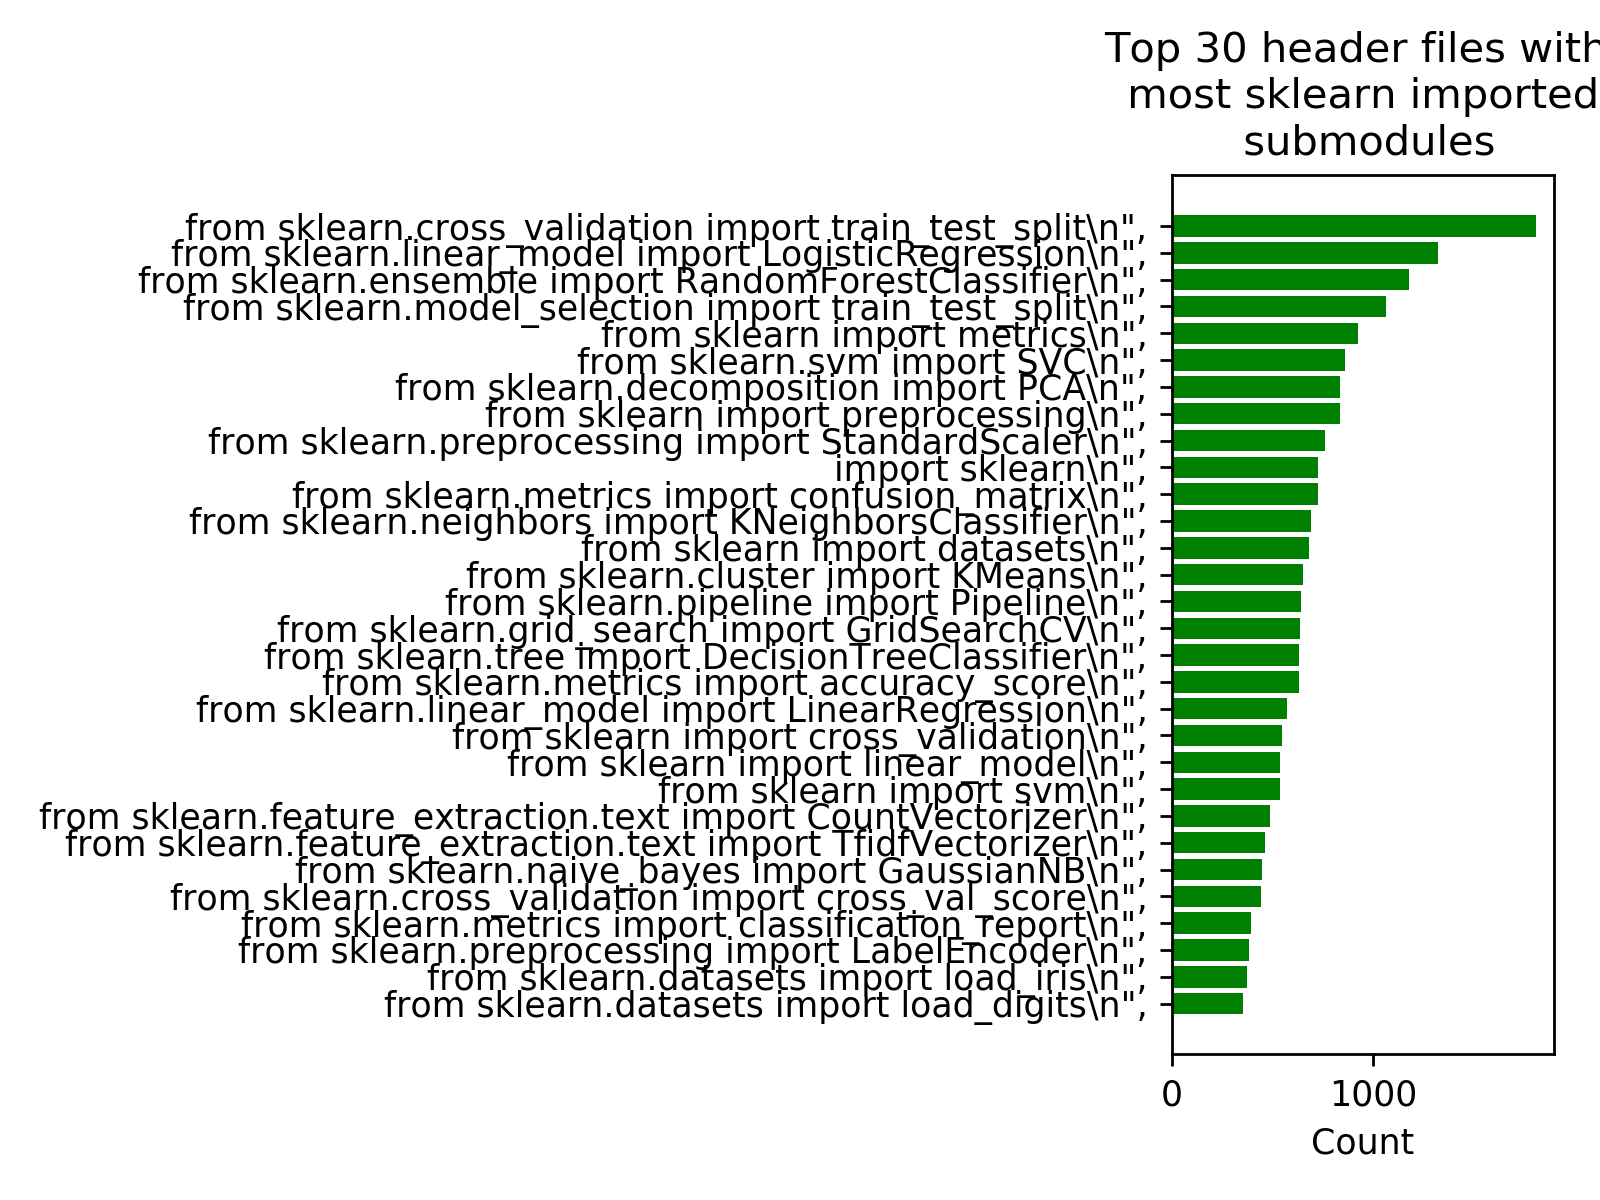

In [34]:
fig, ax = plt.subplots()

header_files = [header for header in mostImportedSubmoduleDF.Head[:30]]
y_pos = range(len(header_files))
count = [count for count in mostImportedSubmoduleDF.Count[:30]]

ax.barh(y_pos, count, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(header_files)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_title('Top 30 header files with \n most sklearn imported \n submodules')
plt.tight_layout()